# Complex FastICA Function

In [7]:
from __future__ import division
import pdb,os,time,warnings
import numpy as np
from math import log
from numpy.linalg import *
from numpy.random import rand

"""
Author: Alex Bujan
Adapted from: Ella Bingham, 1999

Original article citation:
Ella Bingham and Aapo Hyvaerinen, "A fast fixed-point algorithm for 
independent component analysis of complex valued signals", 
International Journal of Neural Systems, Vol. 10, No. 1 (February, 2000) 1-8

Original code url:
http://users.ics.aalto.fi/ella/publications/cfastica_public.m

Date: 12/11/2015

TODO: include arbitrary contrast functions
"""

def abs_sqr(W,X):
    return abs(W.conj().T.dot(X))**2

def complex_FastICA(X,epsilon=.1,algorithm='parallel',\
                    max_iter=100,tol=1e-4,whiten=True,\
                    w_init=None,n_components=None):
    """Performs Fast Independent Component Analysis of complex-valued 
        signals

    Parameters
    ----------

    X : array, shape (n_features,n_samples)
        Input signal X = A S, where A is the mixing 
        matrix and S the latent sources.

    epsilon : float, optional
        Arbitrary constant in the contrast G function 
        used in the approximation to neg-entropy.

    algorithm : {'parallel', 'deflation'}, optional
        Apply a parallel or deflational FASTICA algorithm.

    w_init : (n_components, n_components) array, optional
        Initial un-mixing array.If None (default) then an 
        array of normally distributed r.v.s is used.

    tol: float, optional
        A positive scalar giving the tolerance at which the
        un-mixing matrix is considered to have converged.

    max_iter : int, optional
        Maximum number of iterations.
    
    whiten : boolean, optional
        If True, perform an initial whitening of the data.
        If False, the data is assumed to be already white.

    n_components : int, optional
        Number of components to extract. If None, 
        n_components = n_features.

    Returns
    -------

    W : array, shape (n_components, n_components)
        Estimated un-mixing matrix.

    K : array, shape (n_components, n_features)
        If whiten is 'True', K is the pre-whitening matrix 
        projecting the data onto the principal components. 
        If whiten is 'False', K is 'None'.

    EG : array, shape(n_components,max_iter)
        Expectation of the contrast function E[G(|W'*X|^2)]. 
        This array may be padded with NaNs at the end.

    S : array, shape (n_samples, n_components)
        Estimated sources (S = W K X).
    """

    n,m  = X.shape
    #print(X.shape)
    
    if n_components!=None:
        n = n_components

    if whiten:
        X-=X.mean(1,keepdims=True)
        Ux,Sx = eig(np.cov(X))
        K     = np.sqrt(inv(np.diag(Ux))).dot(Sx.conj().T)[:n]
        X     = K.dot(X)
        del Ux,Sx
    else:
        K = None

    EG = np.ones((n,max_iter))*np.nan

    if algorithm=='deflation':

        W = np.zeros((n,n),dtype=np.complex64)

        for k in range(n):
            if w_init!=None:
                w = w_init[:,k]
            else:
                w = np.random.normal(size=(n,1))+\
                    1j*np.random.normal(size=(n,1))

            w/=norm(w)

            n_iter  = 0

            for i in range(max_iter):

                wold = np.copy(w)

                #derivative of the contrast function
                g  =  1/(epsilon+abs_sqr(w,X))
                #derivative of g
                dg = -1/(epsilon+abs_sqr(w,X))**2

                w  = (X * (w.conj().T.dot(X)).conj() * g).mean(1).reshape((n,1))-\
                     (g + abs_sqr(w,X) * dg).mean() * w

                del g,dg

                w/=norm(w)

                # Decorrelation
                w-=W.dot(W.conj().T).dot(w)
                w/=norm(w)

                EG[k,n_iter] = (np.log(epsilon+abs_sqr(w,X))).mean()

                n_iter+=1

                lim = (abs(abs(wold)-abs(w))).sum()
                if lim<tol:
                    break

            if n_iter==max_iter and lim>tol:
                warnings.warn('FastICA did not converge. Consider increasing '
                              'tolerance or the maximum number of iterations.')

            W[:,k] = w.ravel()

    elif algorithm=='parallel':

        if w_init!=None:
            W = w_init
        else:
            W = np.random.normal(size=(n,n))+\
                1j*np.random.normal(size=(n,n))

        n_iter = 0

        #cache the covariance matrix
        C = np.cov(X)

        for i in range(max_iter):

            Wold = np.copy(W)

            for j in range(n):

                #derivative of the contrast function
                g  =  (1/(epsilon+abs_sqr(W[:,j],X))).reshape((1,m))
                #derivative of g
                dg = -(1/(epsilon+abs_sqr(W[:,j],X))**2).reshape((1,m))

                W[:,j]  = (X * (W[:,j].conj().T.dot(X)).conj() * g).mean(1)-\
                          (g + abs_sqr(W[:,j],X) * dg).mean() * W[:,j]
                del g,dg

            # Symmetric decorrelation
            Uw,Sw = eig(W.conj().T.dot(C.dot(W)))
            W     = W.dot(Sw.dot(inv(np.sqrt(np.diag(Uw))).dot(Sw.conj().T)))
            del Uw,Sw

            EG[:,n_iter] = (np.log(epsilon+abs_sqr(W,X))).mean(1)

            n_iter+=1

            lim = (abs(abs(Wold)-abs(W))).sum()
            if lim < tol:
                break

        if n_iter==max_iter and lim>tol:
            warnings.warn('FastICA did not converge. Consider increasing '
                          'tolerance or the maximum number of iterations.')

    S = W.conj().T.dot(X)

    return K,W,S,EG


# Demo (3 Components)


SSE: 0.0002

SIR: -20.1140


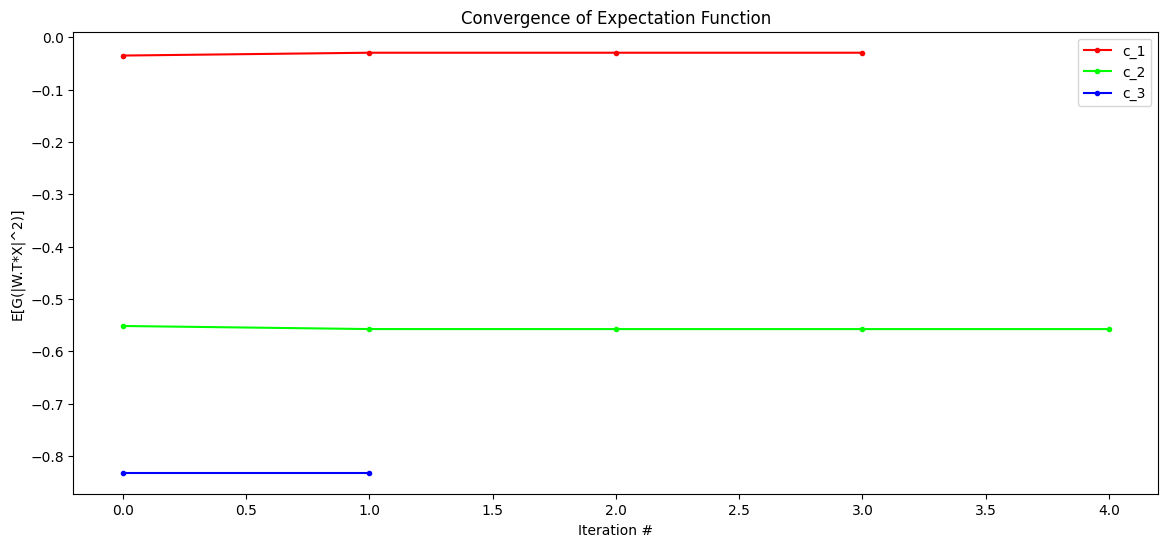

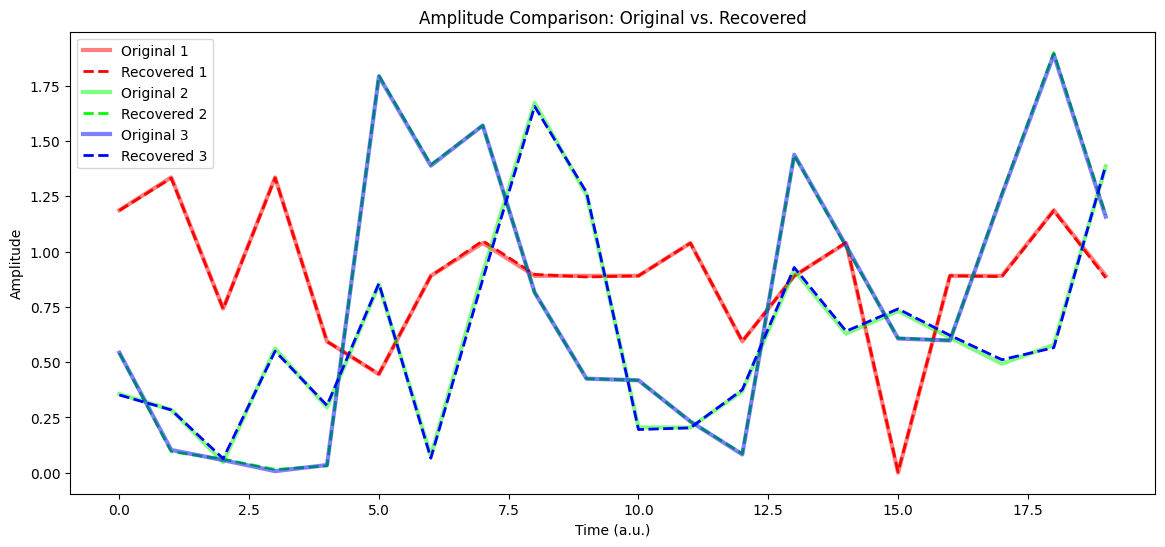

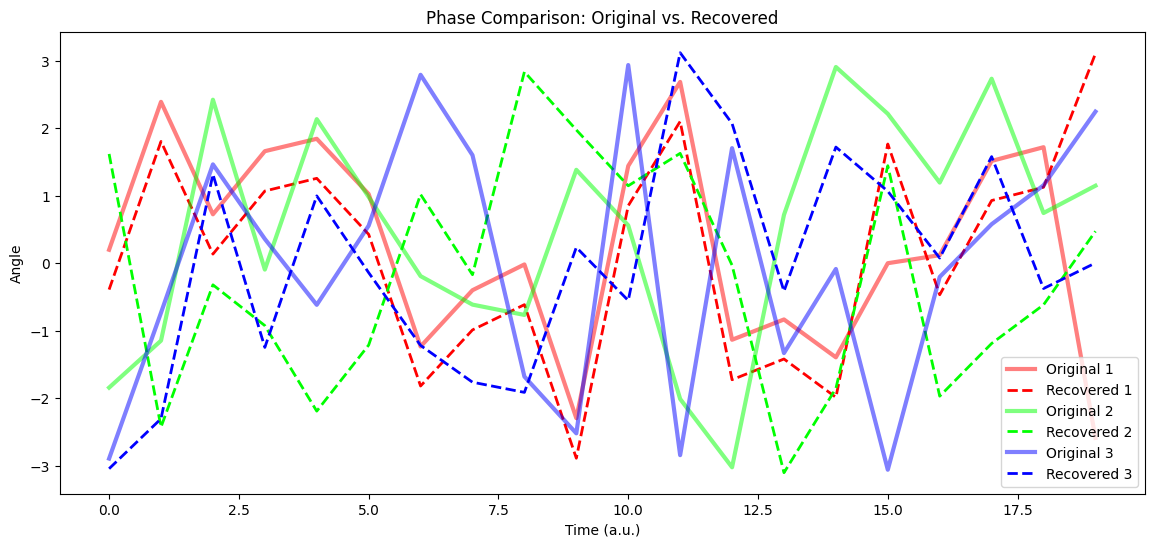

In [8]:
import pdb, os, time, warnings
import numpy as np
from math import log, log10
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

#number of samples
m = 50000
j = 0

#generate parameters for different distributions
bino1 = np.maximum(2, np.ceil(20 * rand()))  # Binomial
exp1 = np.ceil(10 * rand())  # Exponential
norm1 = np.ceil(10 * rand())  # Gaussian noise mean
norm2 = np.ceil(10 * rand())  # Gaussian noise std

#generate independent components (Selecting 3 components)
r = np.random.binomial(bino1, 0.5, size=(1, m))  # Binomial component 
r = np.vstack([r, np.random.exponential(exp1, size=(1, m))])  # Exponential component 
r = np.vstack([r, np.random.normal(norm1, norm2, size=(1, m))])  # Gaussian component

#number of selected components
n = r.shape[0]

#generate random phase shifts for complex transformation
f = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(n, m))

#converting signals to complex by applying random phase shifts
S = r * (np.cos(f) + 1j * np.sin(f))

#standardize signals
S = inv(np.diag(S.std(1))).dot(S)

#mixing matrix (random complex mixing)
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)  #mixed signals

# Apply Complex FastICA
alg = 'deflation'  # or 'parallel'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute SSE and SIR
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW * 1. / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

#visualization
span = 20 
start = np.random.randint(m - span)

colors = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue

#convergence plot
fig1 = plt.figure(figsize=(14, 6))
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# Amplitude Plot (Original vs. Recovered)
fig2 = plt.figure(figsize=(14, 6))  
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

#Phase Angle Plot (Original vs. Recovered)
fig3 = plt.figure(figsize=(14, 6)) 
ax3 = fig3.add_subplot(111)
for j in range(n):
    ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')
ax3.set_title('Phase Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()
